# Semantic Segmentation

### Data loader 생성
- 입력값 (224,224), 출력값 (224,224)의 크기를 갖는 모델을 학습시킬 수 있도록 데이터셋을 파싱해야함.  
- 데이터 로더에 arugmentation을 적용 (albumentations 사용)  
- 학습셋의 일정량을 검증 데이터셋으로 활용할 수 있도록 함.

In [1]:
#필요한 라이브러리를 로드합니다. 
import os
import math
import numpy as np
import tensorflow as tf

from PIL import Image
import matplotlib.pyplot as plt
from skimage.io import imread
from skimage.transform import resize
from glob import glob

from tensorflow.keras.models import *
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import *

tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [2]:
from albumentations import  HorizontalFlip, RandomSizedCrop, Compose, OneOf, Resize

def build_augmentation(is_train=True):
  if is_train:    # 훈련용 데이터일 경우
    return Compose([
                    HorizontalFlip(p=0.5),    # 50%의 확률로 좌우대칭
                    RandomSizedCrop(         # 50%의 확률로 RandomSizedCrop
                        min_max_height=(300, 370),
                        w2h_ratio=370/1242,
                        height=224,
                        width=224,
                        p=0.5
                        ),
                    Resize(              # 입력이미지를 224X224로 resize
                        width=224,
                        height=224
                        )
                    ])
  return Compose([      # 테스트용 데이터일 경우에는 224X224로 resize만 수행합니다. 
                Resize(
                    width=224,
                    height=224
                    )
                ])

#### Albumentation
 Albumentation에서 다양한 augmentation 기법을 확률적으로 적용할 수 있게 해주는 Compose()를 활용

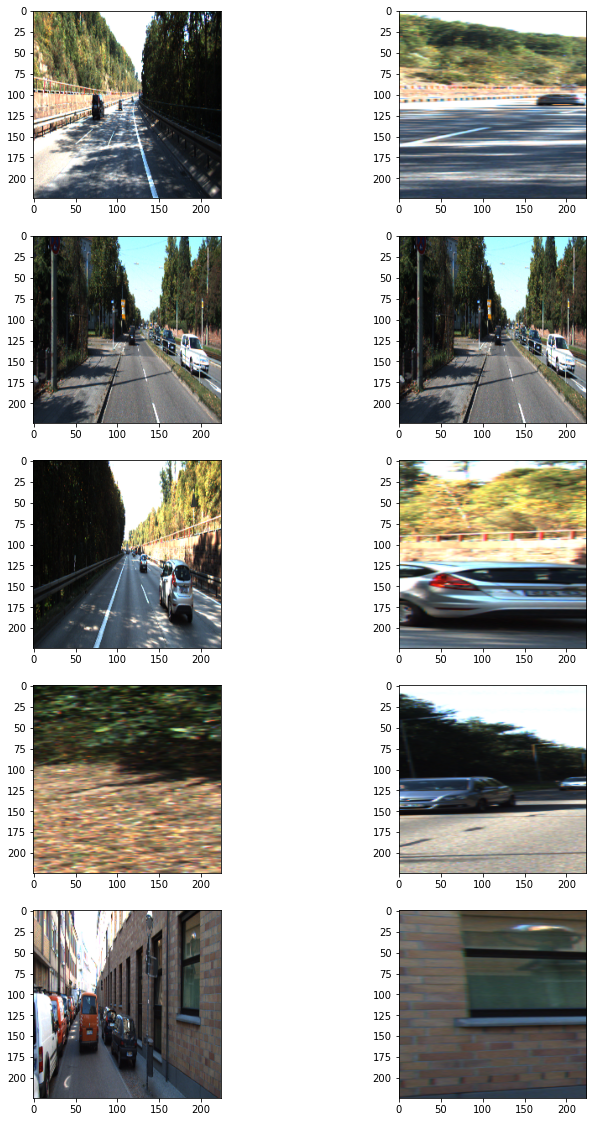

In [3]:
import os

dir_path = os.getenv('HOME')+'/aiffel/semantic_segmentation/data/training'

augmentation = build_augmentation()
input_images = glob(os.path.join(dir_path, "image_2", "*.png"))

# 훈련 데이터셋에서 5개만 가져와 augmentation을 적용해 봅시다.  
plt.figure(figsize=(12, 20))
for i in range(5):
    image = imread(input_images[i]) 
    image_data = {"image":image}
    resized = augmentation(**image_data, is_train=False)
    processed = augmentation(**image_data)
    plt.subplot(5, 2, 2*i+1)
    plt.imshow(resized["image"])  # 왼쪽이 원본이미지
    plt.subplot(5, 2, 2*i+2)
    plt.imshow(processed["image"])  # 오른쪽이 augment된 이미지
  
plt.show()

#### 데이터셋을 구성
tf.keras.utils.Sequence를 상속받은 generator 형태로 데이터를 구성

In [4]:
class KittiGenerator(tf.keras.utils.Sequence):
    '''
    KittiGenerator는 tf.keras.utils.Sequence를 상속받습니다.
    우리가 KittiDataset을 원하는 방식으로 preprocess하기 위해서 Sequnce를 커스텀해 사용합니다.
    '''
    def __init__(self, 
               dir_path,
               batch_size=4,
               img_size=(224, 224, 3),
               output_size=(224, 224),
               is_train=True,
               augmentation=None):
        '''
        dir_path: dataset의 directory path입니다.
        batch_size: batch_size입니다.
        img_size: preprocess에 사용할 입력이미지의 크기입니다.
        output_size: ground_truth를 만들어주기 위한 크기입니다.
        is_train: 이 Generator가 학습용인지 테스트용인지 구분합니다.
        augmentation: 적용하길 원하는 augmentation 함수를 인자로 받습니다.
        '''
        self.dir_path = dir_path
        self.batch_size = batch_size
        self.is_train = is_train
        self.dir_path = dir_path
        self.augmentation = augmentation
        self.img_size = img_size
        self.output_size = output_size

        # load_dataset()을 통해서 kitti dataset의 directory path에서 라벨과 이미지를 확인합니다.
        self.data = self.load_dataset()

    def load_dataset(self):
        # kitti dataset에서 필요한 정보(이미지 경로 및 라벨)를 directory에서 확인하고 로드하는 함수입니다.
        # 이때 is_train에 따라 test set을 분리해서 load하도록 해야합니다.
        input_images = glob(os.path.join(self.dir_path, "image_2", "*.png"))
        label_images = glob(os.path.join(self.dir_path, "semantic", "*.png"))
        input_images.sort()
        label_images.sort()
        assert len(input_images) == len(label_images)
        data = [ _ for _ in zip(input_images, label_images)]

        if self.is_train:
            return data[:-30]
        return data[-30:]

    def __len__(self):
    # Generator의 length로서 전체 dataset을 batch_size로 나누고 소숫점 첫째자리에서 올림한 값을 반환합니다.
        return math.ceil(len(self.data) / self.batch_size)

    def __getitem__(self, index):
        # 입력과 출력을 만듭니다.
        # 입력은 resize및 augmentation이 적용된 input image이고 
        # 출력은 semantic label입니다.
        batch_data = self.data[
                               index*self.batch_size:
                               (index + 1)*self.batch_size
                               ]
        inputs = np.zeros([self.batch_size, *self.img_size])
        outputs = np.zeros([self.batch_size, *self.output_size])

        for i, data in enumerate(batch_data):
            input_img_path, output_path = data
            _input = imread(input_img_path)
            _output = imread(output_path)
            _output = (_output==7).astype(np.uint8)*1
            data = {
              "image": _input,
              "mask": _output,
              }
            augmented = self.augmentation(**data)
            inputs[i] = augmented["image"]/255
            outputs[i] = augmented["mask"]
            return inputs, outputs

    def on_epoch_end(self):
        # 한 epoch가 끝나면 실행되는 함수입니다. 학습중인 경우에 순서를 random shuffle하도록 적용한 것을 볼 수 있습니다.
        self.indexes = np.arange(len(self.data))
        if self.is_train == True :
            np.random.shuffle(self.indexes)
            return self.indexes

In [5]:
augmentation = build_augmentation()
test_preproc = build_augmentation(is_train=False)
        
train_generator = KittiGenerator(
    dir_path, 
    augmentation=augmentation,
)

test_generator = KittiGenerator(
    dir_path, 
    augmentation=test_preproc,
    is_train=False
)

### 시맨틴 세그멘테이션 모델

#### 모델 구조 생성(U-Net)

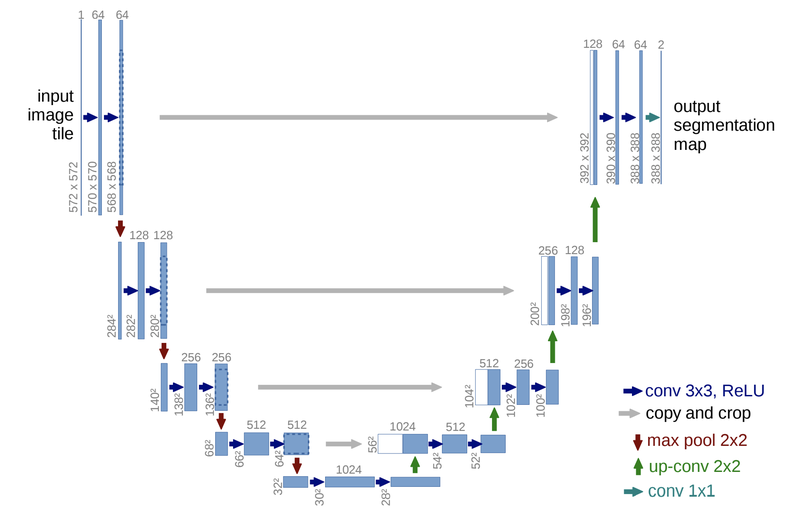

In [6]:
def build_model(input_shape=(224, 224, 3)):
    inputs = Input(input_shape)

    #Contracting Path
    conv1 = Conv2D(64, 3, activation='relu', padding='same',kernel_initializer='he_normal')(inputs)
    conv1 = Conv2D(64, 3, activation='relu', padding='same',kernel_initializer='he_normal')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
    conv2 = Conv2D(128, 3, activation='relu', padding='same',kernel_initializer='he_normal')(pool1)
    conv2 = Conv2D(128, 3, activation='relu', padding='same',kernel_initializer='he_normal')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
    conv3 = Conv2D(256, 3, activation='relu', padding='same',kernel_initializer='he_normal')(pool2)
    conv3 = Conv2D(256, 3, activation='relu', padding='same',kernel_initializer='he_normal')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)
    conv4 = Conv2D(512, 3, activation='relu', padding='same',kernel_initializer='he_normal')(pool3)
    conv4 = Conv2D(512, 3, activation='relu', padding='same',kernel_initializer='he_normal')(conv4)
    drop4 = Dropout(0.5)(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(drop4)

    conv5 = Conv2D(1024, 3, activation='relu', padding='same',kernel_initializer='he_normal')(pool4)  
    conv5 = Conv2D(1024, 3, activation='relu', padding='same',kernel_initializer='he_normal')(conv5)

    #Expanding Path
    drop5 = Dropout(0.5)(conv5)
    up6 = Conv2D(512, 2, activation='relu', padding='same',kernel_initializer='he_normal')(UpSampling2D(size = (2,2))(drop5)) 
    merge6 = concatenate([drop4,up6], axis = 3)
    conv6 = Conv2D(512, 3, activation='relu', padding='same',kernel_initializer='he_normal')(merge6)
    conv6 = Conv2D(512, 3, activation='relu', padding='same',kernel_initializer='he_normal')(conv6)
    up7 = Conv2D(256, 2, activation='relu', padding='same',kernel_initializer='he_normal')(UpSampling2D(size = (2,2))(conv6))
    merge7 = concatenate([conv3,up7], axis = 3)
    conv7 = Conv2D(256, 3, activation='relu', padding='same',kernel_initializer='he_normal')(merge7)
    conv7 = Conv2D(256, 3, activation='relu', padding='same',kernel_initializer='he_normal')(conv7)
    up8 = Conv2D(128, 2, activation='relu', padding='same',kernel_initializer='he_normal')(UpSampling2D(size = (2,2))(conv7))
    merge8 = concatenate([conv2,up8], axis = 3)
    conv8 = Conv2D(128, 3, activation='relu', padding='same',kernel_initializer='he_normal')(merge8)
    conv8 = Conv2D(128, 3, activation='relu', padding='same',kernel_initializer='he_normal')(conv8)
    up9 = Conv2D(64, 2, activation='relu', padding='same',kernel_initializer='he_normal')(UpSampling2D(size = (2,2))(conv8))
    merge9 = concatenate([conv1,up9], axis = 3)
    conv9 = Conv2D(64, 3, activation='relu', padding='same',kernel_initializer='he_normal')(merge9)
    conv9 = Conv2D(64, 3, activation='relu', padding='same',kernel_initializer='he_normal')(conv9)  
    conv9 = Conv2D(2, 3, activation='relu', padding='same',kernel_initializer='he_normal')(conv9)     
    conv10 = Conv2D(1, 1, activation='sigmoid')(conv9)

    model = Model(inputs = inputs, outputs = conv10)
    return model

#### 모델 학습

In [7]:
model = build_model()
model.compile(optimizer = Adam(lr = 1e-4), loss = 'binary_crossentropy')
model.fit_generator(
     generator=train_generator,
     validation_data=test_generator,
     steps_per_epoch=len(train_generator),
     epochs=100,
 )

model_path = dir_path + '/seg_model_unet.h5'
model.save(model_path)  #학습한 모델을 저장해 주세요.

Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/100
43/43 [==============================] - 8s 187ms/step - loss: 0.3680 - val_loss: 0.1520
Epoch 2/100
43/43 [==============================] - 8s 187ms/step - loss: 0.1139 - val_loss: 0.1395
Epoch 3/100
43/43 [==============================] - 7s 173ms/step - loss: 0.1145 - val_loss: 0.0880
Epoch 4/100
43/43 [==============================] - 8s 178ms/step - loss: 0.0901 - val_loss: 0.1166
Epoch 5/100
43/43 [==============================] - 7s 173ms/step - loss: 0.0776 - val_loss: 0.0909
Epoch 6/100
43/43 [==============================] - 8s 175ms/step - loss: 0.0718 - val_loss: 0.1033
Epoch 7/100
43/43 [==============================] - 8s 175ms/step - loss: 0.0778 - val_loss: 0.0723
Epoch 8/100
43/43 [==============================] - 8s 175ms/step - loss: 0.0742 - val_loss: 0.0698
Epoch 9/100
43/43 [==============================] - 8s 175ms/step - loss: 0.0744 - val_loss: 0.0790
Epoch 10/100
43

43/43 [==============================] - 8s 196ms/step - loss: 0.0574 - val_loss: 0.0612
Epoch 77/100
43/43 [==============================] - 8s 196ms/step - loss: 0.0568 - val_loss: 0.0754
Epoch 78/100
43/43 [==============================] - 8s 196ms/step - loss: 0.0537 - val_loss: 0.0728
Epoch 79/100
43/43 [==============================] - 8s 195ms/step - loss: 0.0519 - val_loss: 0.0712
Epoch 80/100
43/43 [==============================] - 8s 197ms/step - loss: 0.0608 - val_loss: 0.0687
Epoch 81/100
43/43 [==============================] - 8s 190ms/step - loss: 0.0527 - val_loss: 0.0615
Epoch 82/100
43/43 [==============================] - 8s 179ms/step - loss: 0.0556 - val_loss: 0.0769
Epoch 83/100
43/43 [==============================] - 8s 180ms/step - loss: 0.0542 - val_loss: 0.0650
Epoch 84/100
43/43 [==============================] - 8s 188ms/step - loss: 0.0513 - val_loss: 0.0666
Epoch 85/100
43/43 [==============================] - 8s 180ms/step - loss: 0.0477 - val_loss: 

In [8]:
model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 224, 224, 64) 1792        input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 224, 224, 64) 36928       conv2d[0][0]                     
__________________________________________________________________________________________________
max_pooling2d (MaxPooling2D)    (None, 112, 112, 64) 0           conv2d_1[0][0]                   
_______________________________________________________________________________________

#### 시각화
`Image.blend`를 이용하여 모델의 출력값과 입력 이미지를 겹쳐서 보이게 하기.

세그멘테이션의 성능을 정략적으로 측정하기 위해 IoU(Intersection over Union)을 사용함.  
- prediction : 모델이 도로 영역이라고 판단한 부분이 1로, 나머지 부분이 0으로 표시된 행렬  
- target : 라벨 데이터에서 도로 영역이 1, 나머지 부분이 0으로 표시된 행렬


In [9]:
def calculate_iou_score(target, prediction):
    intersection = np.logical_and(target, prediction)
    union = np.logical_or(target, prediction)
    iou_score = float(np.sum(intersection)) / float(np.sum(union))
    print('IoU : %f' % iou_score )
    return iou_score

In [10]:
def get_output(model, preproc, image_path, output_path, label_path):
    origin_img = imread(image_path)
    data = {"image":origin_img}
    processed = preproc(**data)
    output = model(np.expand_dims(processed["image"]/255,axis=0))
    output = (output[0].numpy()>=0.5).astype(np.uint8).squeeze(-1)*255  #0.5라는 threshold를 변경하면 도로인식 결과범위가 달라집니다.
    prediction = output/255   # 도로로 판단한 영역
    
    output = Image.fromarray(output)
    background = Image.fromarray(origin_img).convert('RGBA')
    output = output.resize((origin_img.shape[1], origin_img.shape[0])).convert('RGBA')
    output = Image.blend(background, output, alpha=0.5)
    output.show()   # 도로로 판단한 영역을 시각화!
     
    if label_path:   
        label_img = imread(label_path)
        label_data = {"image":label_img}
        label_processed = preproc(**label_data)
        label_processed = label_processed["image"]
        target = (label_processed == 7).astype(np.uint8)*1   # 라벨에서 도로로 기재된 영역

        return output, prediction, target
    else:
        return output, prediction, _

In [11]:
# 완성한 뒤에는 시각화한 결과를 눈으로 확인해봅시다!
i = 1    # i값을 바꾸면 테스트용 파일이 달라집니다. 
output, prediction, target = get_output(
     model, 
     test_preproc,
     image_path=dir_path + f'/image_2/00{str(i).zfill(4)}_10.png',
     output_path=dir_path + f'./result_{str(i).zfill(3)}.png',
     label_path=dir_path + f'/semantic/00{str(i).zfill(4)}_10.png'
 )

calculate_iou_score(target, prediction)

IoU : 0.825751


0.8257509575969357

### 개선된 U-Net 모델 생성
U-Net의 네트워크 구조에 DenseNet의 아이디어를 가미하여 성능을 개선한 모델  

참고 : [U-Net++ 저자 블로그](https://sh-tsang.medium.com/review-unet-a-nested-u-net-architecture-biomedical-image-segmentation-57be56859b20), [UNet++ : A Nested U-Net Architecture for Medical Image Segmentation](https://github.com/CarryHJR/Nested-UNet)

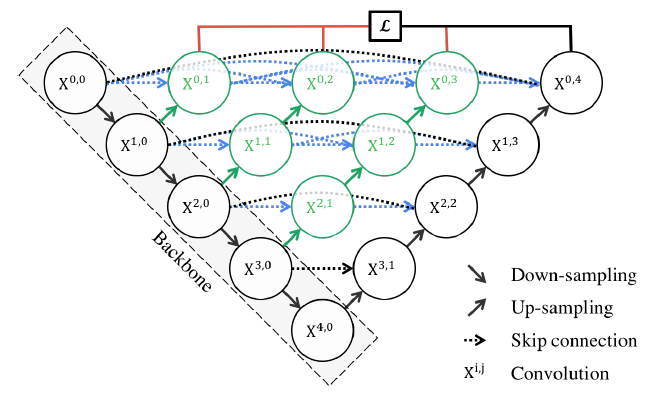

In [12]:
def build_plus_model(input_shape=(224, 224, 3)):
    inputs = Input(input_shape)

    #
    conv1 = Conv2D(64, 3, activation='relu', padding='same',kernel_initializer='he_normal')(inputs)
    conv1 = Conv2D(64, 3, activation='relu', padding='same',kernel_initializer='he_normal')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
    
    #
    conv2 = Conv2D(128, 3, activation='relu', padding='same',kernel_initializer='he_normal')(pool1)
    conv2 = Conv2D(128, 3, activation='relu', padding='same',kernel_initializer='he_normal')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
    
    up1_2 = Conv2DTranspose(nb_filter[0], (2, 2), strides=(2, 2), name='up1_2', padding='same')(conv2)
    merge1_2 = concatenate([conv1, up1_2], axis = 3)
    conv1_2 = Conv2D(64, 3, activation='relu', padding='same',kernel_initializer='he_normal')(merge1_2)
    
    #
    conv3 = Conv2D(256, 3, activation='relu', padding='same',kernel_initializer='he_normal')(pool2)
    conv3 = Conv2D(256, 3, activation='relu', padding='same',kernel_initializer='he_normal')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)
    
    up2_2 = Conv2DTranspose(nb_filter[0], (2, 2), strides=(2, 2), name='up2_2', padding='same')(conv3)
    merge2_2 = concatenate([conv2, up2_2], axis = 3)
    conv2_2 = Conv2D(128, 3, activation='relu', padding='same',kernel_initializer='he_normal')(merge2_2)
    
    up1_3 = Conv2DTranspose(nb_filter[0], (2, 2), strides=(2, 2), name='up1_3', padding='same')(conv2_2)
    merge1_3 = concatenate([conv1, conv1_2, up1_3], axis = 3)
    conv1_3 = Conv2D(64, 3, activation='relu', padding='same',kernel_initializer='he_normal')(merge1_3)  
    
    #
    conv4 = Conv2D(512, 3, activation='relu', padding='same',kernel_initializer='he_normal')(pool3)
    conv4 = Conv2D(512, 3, activation='relu', padding='same',kernel_initializer='he_normal')(conv4)
    drop4 = Dropout(0.5)(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(drop4)
    
    up3_2 = Conv2DTranspose(nb_filter[0], (2, 2), strides=(2, 2), name='up3_2', padding='same')(conv4)
    merge3_2 = concatenate([conv3, up3_2], axis = 3)
    conv3_2 = Conv2D(256, 3, activation='relu', padding='same',kernel_initializer='he_normal')(merge3_2)
    
    up2_3 = Conv2DTranspose(nb_filter[0], (2, 2), strides=(2, 2), name='up2_3', padding='same')(conv3_2)
    merge2_3 = concatenate([conv2, conv2_2, up2_3], axis = 3)
    conv2_3 = Conv2D(128, 3, activation='relu', padding='same',kernel_initializer='he_normal')(merge2_3)  
    
    up1_4 = Conv2DTranspose(nb_filter[0], (2, 2), strides=(2, 2), name='up1_4', padding='same')(conv2_3)
    merge1_4 = concatenate([conv1, conv1_2, conv1_3, up1_4], axis = 3)
    conv1_4 = Conv2D(64, 3, activation='relu', padding='same',kernel_initializer='he_normal')(merge1_4)
    
    #
    conv5 = Conv2D(1024, 3, activation='relu', padding='same',kernel_initializer='he_normal')(pool4)  
    conv5 = Conv2D(1024, 3, activation='relu', padding='same',kernel_initializer='he_normal')(conv5)
    
    up4_2 = Conv2DTranspose(nb_filter[0], (2, 2), strides=(2, 2), name='up4_2', padding='same')(conv5)
    merge4_2 = concatenate([conv4, up4_2], axis = 3)
    conv4_2 = Conv2D(512, 3, activation='relu', padding='same',kernel_initializer='he_normal')(merge4_2)
    
    up3_3 = Conv2DTranspose(nb_filter[0], (2, 2), strides=(2, 2), name='up3_3', padding='same')(conv4_2)
    merge3_3 = concatenate([conv3, conv3_2, up3_3], axis = 3)
    conv3_3 = Conv2D(256, 3, activation='relu', padding='same',kernel_initializer='he_normal')(merge3_3)  
    
    up2_4 = Conv2DTranspose(nb_filter[0], (2, 2), strides=(2, 2), name='up2_4', padding='same')(conv3_3)
    merge2_4 = concatenate([conv2, conv2_2, conv2_3, up2_4], axis = 3)
    conv2_4 = Conv2D(128, 3, activation='relu', padding='same',kernel_initializer='he_normal')(merge2_4)
    
    up1_5 = Conv2DTranspose(nb_filter[0], (2, 2), strides=(2, 2), name='up1_5', padding='same')(conv2_4)
    merge1_5 = concatenate([conv1, conv1_2, conv1_3, conv1_4, up1_5], axis = 3)
    conv1_5 = Conv2D(64, 3, activation='relu', padding='same',kernel_initializer='he_normal')(merge1_5)
    
    output_1 = Conv2D(1,1,activation='sigmoid')(conv1_2)
    output_2 = Conv2D(1,1,activation='sigmoid')(conv1_3) 
    output_3 = Conv2D(1,1,activation='sigmoid')(conv1_4)
    output_4 = Conv2D(1,1,activation='sigmoid')(conv1_5) 
    
    model2 = Model(inputs = inputs, output=[output_1, output_2, output_3,output_4])
    return model2

# backup
def build_plus_model(input_shape=(224, 224, 3)):
    inputs = Input(input_shape)

    #
    conv1 = Conv2D(64, 3, activation='relu', padding='same',kernel_initializer='he_normal')(inputs)
    conv1 = Conv2D(64, 3, activation='relu', padding='same',kernel_initializer='he_normal')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
    
    #
    conv2 = Conv2D(128, 3, activation='relu', padding='same',kernel_initializer='he_normal')(pool1)
    conv2 = Conv2D(128, 3, activation='relu', padding='same',kernel_initializer='he_normal')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
    
    up1_2 = Conv2DTranspose(nb_filter[0], (2, 2), strides=(2, 2), name='up1_2', padding='same')(conv2)
    merge1_2 = concatenate([conv1, up1_2], axis = 3)
    conv1_2 = Conv2D(64, 3, activation='relu', padding='same',kernel_initializer='he_normal')(merge1_2)
    
    #
    conv3 = Conv2D(256, 3, activation='relu', padding='same',kernel_initializer='he_normal')(pool2)
    conv3 = Conv2D(256, 3, activation='relu', padding='same',kernel_initializer='he_normal')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)
    
    up2_2 = Conv2DTranspose(nb_filter[0], (2, 2), strides=(2, 2), name='up2_2', padding='same')(conv3)
    merge2_2 = concatenate([conv2, up2_2], axis = 3)
    conv2_2 = Conv2D(128, 3, activation='relu', padding='same',kernel_initializer='he_normal')(merge2_2)
    
    up1_3 = Conv2DTranspose(nb_filter[0], (2, 2), strides=(2, 2), name='up1_3', padding='same')(conv2_2)
    merge1_3 = concatenate([conv1, conv1_2, up1_3], axis = 3)
    conv1_3 = Conv2D(64, 3, activation='relu', padding='same',kernel_initializer='he_normal')(merge1_3)  
    
    #
    conv4 = Conv2D(512, 3, activation='relu', padding='same',kernel_initializer='he_normal')(pool3)
    conv4 = Conv2D(512, 3, activation='relu', padding='same',kernel_initializer='he_normal')(conv4)
    drop4 = Dropout(0.5)(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(drop4)
    
    up3_2 = Conv2DTranspose(nb_filter[0], (2, 2), strides=(2, 2), name='up3_2', padding='same')(conv4)
    merge3_2 = concatenate([conv3, up3_2], axis = 3)
    conv3_2 = Conv2D(256, 3, activation='relu', padding='same',kernel_initializer='he_normal')(merge3_2)
    
    up2_3 = Conv2DTranspose(nb_filter[0], (2, 2), strides=(2, 2), name='up2_3', padding='same')(conv3_2)
    merge2_3 = concatenate([conv2, conv2_2, up2_3], axis = 3)
    conv2_3 = Conv2D(128, 3, activation='relu', padding='same',kernel_initializer='he_normal')(merge2_3)  
    
    up1_4 = Conv2DTranspose(nb_filter[0], (2, 2), strides=(2, 2), name='up1_4', padding='same')(conv2_3)
    merge1_4 = concatenate([conv1, conv1_2, conv1_3, up1_4], axis = 3)
    conv1_4 = Conv2D(64, 3, activation='relu', padding='same',kernel_initializer='he_normal')(merge1_4)
    
    #
    conv5 = Conv2D(1024, 3, activation='relu', padding='same',kernel_initializer='he_normal')(pool4)  
    conv5 = Conv2D(1024, 3, activation='relu', padding='same',kernel_initializer='he_normal')(conv5)
    
    up4_2 = Conv2DTranspose(nb_filter[0], (2, 2), strides=(2, 2), name='up4_2', padding='same')(conv5)
    merge4_2 = concatenate([conv4, up4_2], axis = 3)
    conv4_2 = Conv2D(512, 3, activation='relu', padding='same',kernel_initializer='he_normal')(merge4_2)
    
    up3_3 = Conv2DTranspose(nb_filter[0], (2, 2), strides=(2, 2), name='up3_3', padding='same')(conv4_2)
    merge3_3 = concatenate([conv3, conv3_2, up3_3], axis = 3)
    conv3_3 = Conv2D(256, 3, activation='relu', padding='same',kernel_initializer='he_normal')(merge3_3)  
    
    up2_4 = Conv2DTranspose(nb_filter[0], (2, 2), strides=(2, 2), name='up2_4', padding='same')(conv3_3)
    merge2_4 = concatenate([conv2, conv2_2, conv2_3, up2_4], axis = 3)
    conv2_4 = Conv2D(128, 3, activation='relu', padding='same',kernel_initializer='he_normal')(merge2_4)
    
    up1_5 = Conv2DTranspose(nb_filter[0], (2, 2), strides=(2, 2), name='up1_5', padding='same')(conv2_4)
    merge1_5 = concatenate([conv1, conv1_2, conv1_3, conv1_4, up1_5], axis = 3)
    conv1_5 = Conv2D(64, 3, activation='relu', padding='same',kernel_initializer='he_normal')(merge1_5)
    
    output_1 = Conv2D(1,1,activation='sigmoid')(conv1_2)
    output_2 = Conv2D(1,1,activation='sigmoid')(conv1_3) 
    output_3 = Conv2D(1,1,activation='sigmoid')(conv1_4)
    output_4 = Conv2D(1,1,activation='sigmoid')(conv1_5) 
    
    model2 = Model(inputs = inputs, output=[output_1, output_2, output_3,output_4])
    return model2

In [13]:
model2 = build_model()
model2.compile(optimizer = Adam(lr = 1e-4), loss = 'binary_crossentropy')
model2.fit_generator(
     generator=train_generator,
     validation_data=test_generator,
     steps_per_epoch=len(train_generator),
     epochs=100,
 )

model2_path = dir_path + '/seg_model_unet_plus.h5'
model2.save(model_path)  #학습한 모델을 저장해 주세요.

Epoch 1/100
43/43 [==============================] - 9s 204ms/step - loss: 0.4834 - val_loss: 0.1397
Epoch 2/100
43/43 [==============================] - 8s 197ms/step - loss: 0.1271 - val_loss: 0.1011
Epoch 3/100
43/43 [==============================] - 8s 197ms/step - loss: 0.0910 - val_loss: 0.0681
Epoch 4/100
43/43 [==============================] - 8s 197ms/step - loss: 0.0819 - val_loss: 0.0778
Epoch 5/100
43/43 [==============================] - 8s 197ms/step - loss: 0.0644 - val_loss: 0.0756
Epoch 6/100
43/43 [==============================] - 8s 197ms/step - loss: 0.0755 - val_loss: 0.0700
Epoch 7/100
43/43 [==============================] - 8s 196ms/step - loss: 0.0636 - val_loss: 0.0685
Epoch 8/100
43/43 [==============================] - 8s 196ms/step - loss: 0.0602 - val_loss: 0.0647
Epoch 9/100
43/43 [==============================] - 8s 196ms/step - loss: 0.0564 - val_loss: 0.0563
Epoch 10/100
43/43 [==============================] - 8s 196ms/step - loss: 0.0725 - val_lo

43/43 [==============================] - 8s 182ms/step - loss: 0.0359 - val_loss: 0.0407
Epoch 80/100
43/43 [==============================] - 8s 185ms/step - loss: 0.0338 - val_loss: 0.0440
Epoch 81/100
43/43 [==============================] - 8s 180ms/step - loss: 0.0366 - val_loss: 0.0412
Epoch 82/100
43/43 [==============================] - 8s 178ms/step - loss: 0.0348 - val_loss: 0.0405
Epoch 83/100
43/43 [==============================] - 8s 188ms/step - loss: 0.0306 - val_loss: 0.0360
Epoch 84/100
43/43 [==============================] - 8s 195ms/step - loss: 0.0304 - val_loss: 0.0421
Epoch 85/100
43/43 [==============================] - 9s 219ms/step - loss: 0.0344 - val_loss: 0.0605
Epoch 86/100
43/43 [==============================] - 9s 219ms/step - loss: 0.0386 - val_loss: 0.0402
Epoch 87/100
43/43 [==============================] - 9s 220ms/step - loss: 0.0331 - val_loss: 0.0416
Epoch 88/100
43/43 [==============================] - 9s 219ms/step - loss: 0.0398 - val_loss: 

In [14]:
from tensorflow import keras
model2.summary()
#keras.utils.plot_model(model, to_file="U-Net++.png", show_shapes=True)

Model: "functional_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv2d_24 (Conv2D)              (None, 224, 224, 64) 1792        input_2[0][0]                    
__________________________________________________________________________________________________
conv2d_25 (Conv2D)              (None, 224, 224, 64) 36928       conv2d_24[0][0]                  
__________________________________________________________________________________________________
max_pooling2d_4 (MaxPooling2D)  (None, 112, 112, 64) 0           conv2d_25[0][0]                  
_______________________________________________________________________________________

In [15]:
# 완성한 뒤에는 시각화한 결과를 눈으로 확인해봅시다!
i = 1    # i값을 바꾸면 테스트용 파일이 달라집니다. 
output, prediction, target = get_output(
     model2, 
     test_preproc,
     image_path=dir_path + f'/image_2/00{str(i).zfill(4)}_10.png',
     output_path=dir_path + f'./result_{str(i).zfill(3)}.png',
     label_path=dir_path + f'/semantic/00{str(i).zfill(4)}_10.png'
 )

calculate_iou_score(target, prediction)

IoU : 0.868009


0.86800878996243

### UNet vs UNet++

In [16]:
unet_path = dir_path + '/seg_model_unet.h5'
unet_plus_path = dir_path + '/seg_model_unet_plus.h5'

unet_model = tf.keras.models.load_model(unet_path)
unet_plus_model = tf.keras.models.load_model(unet_plus_path)

In [17]:
unet_iou = []
unet_plus_iou = []
for i in range(5):
    output, prediction, target = get_output(model, 
                                            test_preproc,
                                            image_path=dir_path + f'/image_2/00{str(i).zfill(4)}_10.png',
                                            output_path=dir_path + f'./result_{str(i).zfill(3)}.png',
                                            label_path=dir_path + f'/semantic/00{str(i).zfill(4)}_10.png'
     )
    unet_iou.append(calculate_iou_score(target, prediction))
    
    output, prediction, target = get_output(model2, 
                                            test_preproc,
                                            image_path=dir_path + f'/image_2/00{str(i).zfill(4)}_10.png',
                                            output_path=dir_path + f'./result_{str(i).zfill(3)}.png',
                                            label_path=dir_path + f'/semantic/00{str(i).zfill(4)}_10.png'
     )
    unet_plus_iou.append(calculate_iou_score(target, prediction))

IoU : 0.898155
IoU : 0.904322
IoU : 0.825751
IoU : 0.868009
IoU : 0.644989
IoU : 0.635197
IoU : 0.626160
IoU : 0.641822
IoU : 0.701086
IoU : 0.738437


In [18]:
# 사진을 노트북에 띄우기 위한 get_output
def get_output(model, preproc, image_path, output_path):
    origin_img = imread(image_path)
    data = {"image":origin_img}
    processed = preproc(**data)
    output = model(np.expand_dims(processed["image"]/255,axis=0))
    output = (output[0].numpy()>=0.5).astype(np.uint8).squeeze(-1)*255  #0.5라는 threshold를 변경하면 도로인식 결과범위가 달라집니다.
    prediction = output/255   # 도로로 판단한 영역
    
    output = Image.fromarray(output)
    background = Image.fromarray(origin_img).convert('RGBA')
    output = output.resize((origin_img.shape[1], origin_img.shape[0])).convert('RGBA')
    output = Image.blend(background, output, alpha=0.5)
    output.show()   # 도로로 판단한 영역을 시각화!
    
    return output

In [19]:
import pandas as pd
result = pd.DataFrame({'UNet' : unet_iou,
                       'UNet++' : unet_plus_iou    
})

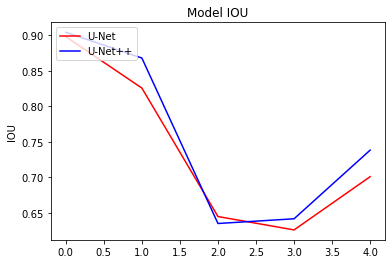

In [20]:
# Acuuracy 시각화
plt.plot(unet_iou, 'r')
plt.plot(unet_plus_iou, 'b')
plt.title('Model IOU')
plt.ylabel('IOU')
plt.legend(['U-Net', 'U-Net++'], loc='upper left')
plt.show()

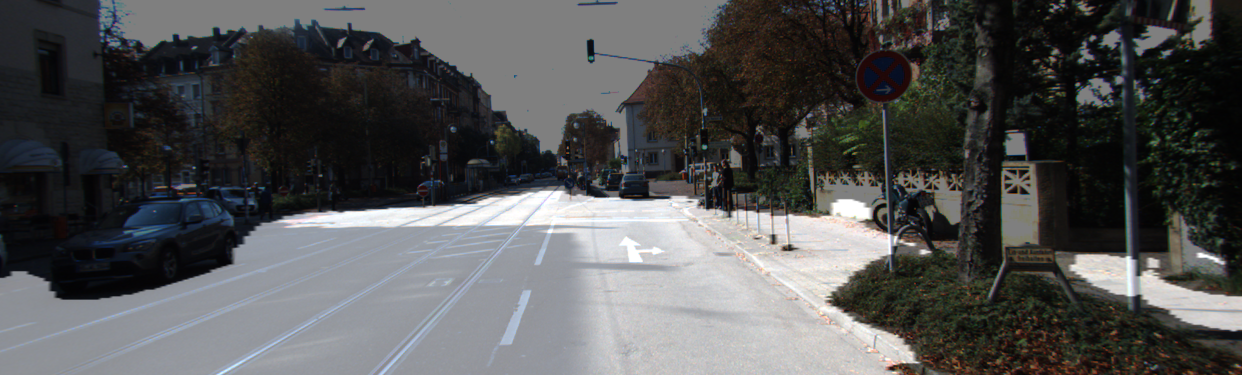

In [21]:
# 완성한 뒤에는 시각화한 결과를 눈으로 확인해봅시다!
i = 1    # i값을 바꾸면 테스트용 파일이 달라집니다. 
get_output(
     model, 
     test_preproc,
     image_path=dir_path + f'/image_2/00{str(i).zfill(4)}_10.png',
     output_path=dir_path + f'./result_{str(i).zfill(3)}.png',
 )


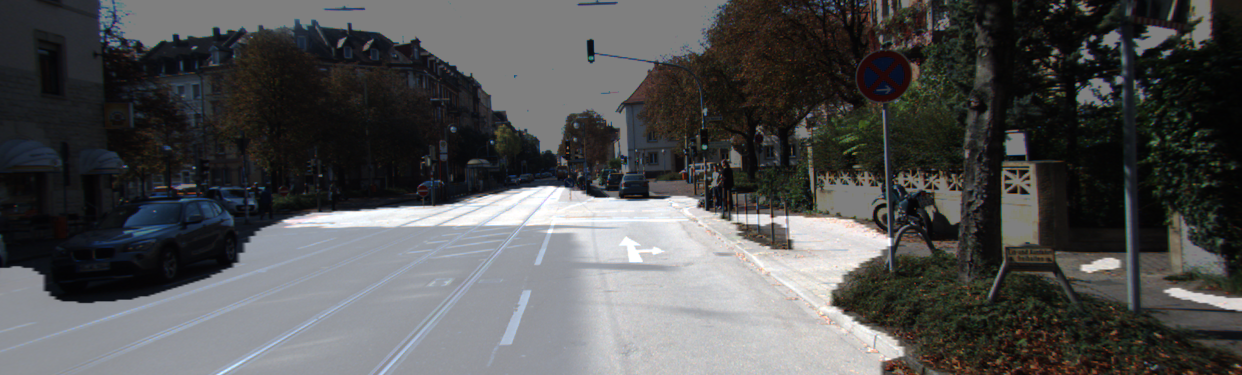

In [22]:
# 완성한 뒤에는 시각화한 결과를 눈으로 확인해봅시다!
i = 1    # i값을 바꾸면 테스트용 파일이 달라집니다. 
get_output(
     model2, 
     test_preproc,
     image_path=dir_path + f'/image_2/00{str(i).zfill(4)}_10.png',
     output_path=dir_path + f'./result_{str(i).zfill(3)}.png',
 )